<a href="https://colab.research.google.com/github/aidancrilly/AIMSLecture/blob/main/ColabExercises/Exercise1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import jax.numpy as jnp
import jax

In this exercise, we will look at computational graphs and automatic differentiaton. For this we will use Python JAX, a machine learning framework developed by Google.

To aid our understanding, we will visualise the computational graphs using the functions below. It is not important to understand exactly how this is done.

In [27]:
import pydot
from jaxlib import xla_client
from IPython.display import Image, display

def view_pydot(pdot):
  plt = Image(pdot.create_png())
  display(plt)

def todotgraph(x):
  """
  Credit to: https://bnikolic.co.uk/blog/python/jax/2022/02/22/jax-outputgraph-rev.html
  """
  return xla_client._xla.hlo_module_to_dot_graph(xla_client._xla.hlo_module_from_text(x))

def viz_computational_graph(f,x,compiled=False):
  """
  Produces a visualisation of a computational graph for function f with input x
  """
  if(compiled):
    z = jax.jit(f).lower(x).compile().as_text()
    z = todotgraph(z)
  else:
    z = jax.jit(f).lower(x).compiler_ir('hlo').as_hlo_dot_graph()
  with open("t.dot", "w") as f:
    f.write(z)
  (graph,) = pydot.graph_from_dot_file('t.dot')
  view_pydot(graph)

#Part 1

We will write a number of simple functions, use JAX's AD to differentiate them and visualise the computational graphs.

For this part of the exercise, we define 3 functions of interest:

tanh(x) : $$ \tanh(\vec{x}) = \frac{1-e^{-2\vec{x}}}{1+e^{-2\vec{x}}} $$

log_mean_tanh(x) : $$ \text{log_mean_tanh}(\vec{x}) = \ln\left(\frac{1}{N}∑_i^N \tanh(x_i) \right)$$

grad_log_mean_tanh(x) : $$ \text{grad_log_mean_tanh}(\vec{x}) = \frac{\partial \text{log_mean_tanh}}{\partial \vec{x}}  $$

Below are a number of incomplete function defintions. Fill in the missing parts, making use of the JAX numpy library, and use viz_computational_graph to visualise their graphs.

N.B. To create the graph we need to "stage out" a specialised version of the Python function to one that operates on restricted data types (see https://jax.readthedocs.io/en/latest/aot.html for detail). To do this we must provide an argument to the function, in the following we will simple use a 1-D array of ones with length 100.

Some tips for reading the graphs:

1. Data types are explicitly given, any static operands will typically show up as f32[].
2. For binary operations, the numbers on top of the arrows into the graph node denote the position of the operand. For example, into a subtract operation the result is {Operand 0} - {Operand 1}.
3. Without compilation, the computational graphs are no necessarily optimised. When compiled, optimisations such as loop fusion will be included. While optimal, they can be less human-interpretable.

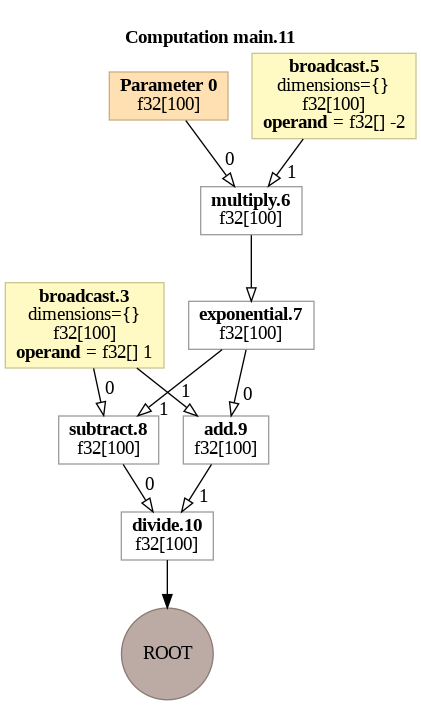

In [34]:
def tanh(x):
  y = jnp.exp(-2.0*x)
  res = (1-y)/(1+y)
  return res

def log_mean_tanh(x):
  y = tanh(x)
  return jnp.log(jnp.mean(y))

def grad_log_mean_tanh(x):
  return jax.grad(log_mean_tanh)(x)

viz_computational_graph(tanh,jnp.ones(100),compiled=False)



Visualise and inspect the results for each function, do they make sense? For the gradient operation, is it a clear extension of the original graph? How does compilation alter the graph?


# Part 2

We will now use the above techniques to inspect how AD computes the adjoint solution of an ODE. We will follow the example from the lecture notes, an exponential decay:

$$ \frac{dy}{dt} = - \frac{y}{\tau} $$

